In [14]:
import json
import numpy as np
import scipy as sp
#matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
import bisect
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, eigs
from numpy.linalg import matrix_rank
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import os
import time

In [15]:
user_data = []
start = time.time()
with open('yelp_dataset/yelp_academic_dataset_user.json', encoding="utf8") as fin:
    print('Reading yelp_academic_dataset_user.json')
    for line in fin:
        user = json.loads(line)
        user_data.append(user)
end = time.time()
duration = end-start
print("Time taken to load user data: %d seconds" %duration)

Reading yelp_academic_dataset_user.json
Time taken to load user data: 23 seconds


In [16]:
business_data = []
start = time.time()
with open('yelp_dataset/yelp_academic_dataset_business.json', encoding="utf8") as fin:
    print('Reading yelp_academic_dataset_business.json')
    for line in fin:
        business = json.loads(line)
        business_data.append(business)

end = time.time()
duration = end-start
print("Time taken to load business data: %d seconds" %duration)

Reading yelp_academic_dataset_business.json
Time taken to load business data: 2 seconds


In [17]:
print(str(len(user_data)) + ' user records loaded')
print(str(len(business_data)) + ' business records loaded')

2189457 user records loaded
160585 business records loaded


In [18]:
# Filter businesses to only show restaurants
restaurant_category = 'Restaurants'
restaurant_data = []
for business in business_data:
    try:
        if restaurant_category in business.get('categories',):
            restaurant_data.append(business)
    except:
        pass

print(str(len(business_data)) + ' business records reduced to ' + str(len(restaurant_data)) + ' restaurant records')

160585 business records reduced to 50763 restaurant records


In [19]:
TX_restaurants = [restaurant for restaurant in restaurant_data if 'TX' in restaurant.get('state')]
TX_restaurants = [restaurant for restaurant in TX_restaurants if restaurant.get('review_count') >= 40]
print(str(len(restaurant_data)) + ' restaurant records reduced to ' + str(len(TX_restaurants)) + ' Texas restaurants with 40 or more reviews')

50763 restaurant records reduced to 3270 Texas restaurants with 40 or more reviews


In [20]:
with open('TX_restaurants.json', 'a') as outfile:
    json.dump(TX_restaurants, outfile, indent=1)

In [21]:
# Remove all users that don't have 50 or more reviews
max_review_count = 50
user_data = [user for user in user_data if user.get('review_count') >= max_review_count]

review_data = []
TX_restaurants_id = set([restaurant.get('business_id') for restaurant in TX_restaurants])
valid_user_id = set([user.get('user_id') for user in user_data])
start = time.time()
with open('yelp_dataset/yelp_academic_dataset_review.json', encoding="utf8") as fin:
    print('Reading yelp_academic_dataset_review.json')
    for line in fin:
        review = json.loads(line)
        if review.get('business_id') in TX_restaurants_id:
            if review.get('user_id') in valid_user_id:
                review_data.append(review)

end = time.time()
duration_without_dr = end-start
print("Time taken to load review data: %d seconds" %duration_without_dr)

Reading yelp_academic_dataset_review.json
Time taken to load review data: 53 seconds


In [22]:
from collections import Counter
orginal_review_count = len(review_data)

while True:
    old_review_count = len(review_data)
    filter_user = set()
    filter_restaurant = set()
    #user_review_count_TX = Counter(k['user_id'] for k in review_data if k.get('user_id'))
    #restaurant_review_count_TX = Counter(k['business_id'] for k in review_data if k.get('business_id'))
    user_review_count_TX = Counter(k['user_id'] for k in review_data)
    restaurant_review_count_TX = Counter(k['business_id'] for k in review_data)
    #for user, count in user_review_count_TX.most_common():
    for user, user_count in user_review_count_TX.most_common():
        if user_count >= max_review_count:
            filter_user.add(user)

    #for biz, count in restaurant_review_count_TX.most_common():
    for biz, biz_count in restaurant_review_count_TX.most_common():
        if biz_count >= 40:
            filter_restaurant.add(biz)       
    review_data[:] = [x for x in review_data if x.get('user_id') in filter_user and x.get('business_id') in filter_restaurant]
    if old_review_count == len(review_data):
        break
print(str(orginal_review_count) + ' review records for Texas reduced to ' + str(len(review_data)) + ' reviews from users with 40 or more reviews and on restaurants with 40 or more reviews')

373626 review records for Texas reduced to 87592 reviews from users with 40 or more reviews and on restaurants with 40 or more reviews


5.0    24971
4.0    35851
3.0    17280
2.0     7073
1.0     2417
Name: stars, dtype: int64


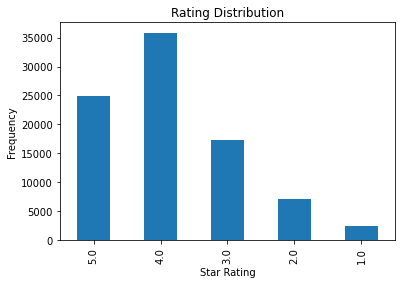

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(review_data)
print(df['stars'].value_counts().sort_index(ascending=False))
df.stars.value_counts().sort_index(ascending=False).plot(kind="bar",title='Rating Distribution',xlabel='Star Rating',ylabel="Frequency");

In [24]:
with open('TX_reviews.json', 'a') as outfile:
    json.dump(review_data, outfile, indent=1)

In [27]:
TX_users = []
TX_user_id = set([review.get('user_id') for review in review_data])
for user in user_data:
    if user.get('user_id') in TX_user_id:
        TX_users.append(user)
print(str(len(TX_users)) + ' users in texas with more than '+ str(max_review_count) +' reviews on popular restaurants')

1194 users in texas with more than 40 reviews on popular restaurants


In [26]:
with open('TX_users.json', 'a') as outfile:
    json.dump(TX_users, outfile, indent=1)